# Benchmark N-Queens avec différentes configurations du solver

Ce notebook effectue un benchmark du problème des N-Queens avec différentes configurations du solver.

## Objectifs
- Générer les instances CSP via instances/generate_nqueens.py
- Exécuter le solver CPSolver avec différentes configurations :
  - AC + Forward checking
  - AC sans Forward checking
  - Sans AC + Forward checking
  - Sans AC sans Forward checking
- Analyse de performances


In [1]:
import subprocess
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re

## Configuration des chemins


In [2]:
# Chemins vers les outils
SOLVER_PATH = "../Solver/CPSolver"
GENERATOR_PATH = "../instances/generate_nqueens.py"
INSTANCES_DIR = "../instances/instances"
SOLUTIONS_DIR = "../solutions/solutions"

# Créer les répertoires s'ils n'existent pas
os.makedirs(INSTANCES_DIR, exist_ok=True)
os.makedirs(SOLUTIONS_DIR, exist_ok=True)

print(f"Solver: {SOLVER_PATH}")
print(f"Generator: {GENERATOR_PATH}")
print(f"Instances dir: {INSTANCES_DIR}")
print(f"Solutions dir: {SOLUTIONS_DIR}")

Solver: ../Solver/CPSolver
Generator: ../instances/generate_nqueens.py
Instances dir: ../instances/instances
Solutions dir: ../solutions/solutions


## Génération des instances CSP


In [3]:
def generate_instances(n_min=1, n_max=8):
    """Génère les instances CSP pour n de n_min à n_max"""
    generated_files = []
    
    for n in range(n_min, n_max + 1):
            
        instance_file = f"{INSTANCES_DIR}/nqueens_{n}.csp"
        
        # Générer l'instance si elle n'existe pas déjà
        if not os.path.exists(instance_file):
            try:
                cmd = ["python3", GENERATOR_PATH, str(n), "-o", INSTANCES_DIR]
                result = subprocess.run(cmd, capture_output=True, text=True, check=True)
                print(f"N={n}: Instance générée - {instance_file}")
                print(f"  {result.stdout.strip()}")
            except subprocess.CalledProcessError as e:
                print(f"Erreur génération N={n}: {e.stderr}")
                continue
        else:
            print(f"N={n}: Instance existante - {instance_file}")
        
        generated_files.append((n, instance_file))
    
    return generated_files

# Générer toutes les instances
instances = generate_instances(1, 10)
print(f"\nTotal instances générées: {len(instances)}")

Erreur génération N=1: 
Erreur génération N=2: 
Erreur génération N=3: 
N=4: Instance existante - ../instances/instances/nqueens_4.csp
N=5: Instance existante - ../instances/instances/nqueens_5.csp
N=6: Instance existante - ../instances/instances/nqueens_6.csp
N=7: Instance existante - ../instances/instances/nqueens_7.csp
N=8: Instance existante - ../instances/instances/nqueens_8.csp
N=9: Instance existante - ../instances/instances/nqueens_9.csp
N=10: Instance existante - ../instances/instances/nqueens_10.csp

Total instances générées: 7


## Configurations du solver et fonction de résolution


In [4]:
# Configurations du solver (ordre par performance croissante)
# Note: -a désactive AC-3, -c désactive forward checking
SOLVER_CONFIGS = {
    'NoAC_NoForward': {'disable_ac': True, 'disable_forward': True, 'name': 'NoAC_NoForward'},
    'NoAC_Forward': {'disable_ac': True, 'disable_forward': False, 'name': 'NoAC_Forward'},
    'AC_NoForward': {'disable_ac': False, 'disable_forward': True, 'name': 'AC_NoForward'},
    'AC_Forward': {'disable_ac': False, 'disable_forward': False, 'name': 'AC_Forward'}
}

def parse_solver_output(output_text):
    """Parse la sortie du solver pour extraire les informations"""
    lines = output_text.split('\n')
    
    # Rechercher le nombre de solutions
    solutions_count = 0
    solving_time = 0.0
    nodes_explored = 0
    backtracks = 0
    status = "unknown"
    
    for line in lines:
        # Chercher le nombre de solutions - format exact: "Solutions found: X"
        if "Solutions found:" in line:
            # Extraire le nombre après "Solutions found:"
            match = re.search(r'Solutions found:\s*(\d+)', line)
            if match:
                solutions_count = int(match.group(1))
        
        # Chercher le temps de résolution - format exact: "Solving time: Xms" ou "Solving time: Xs"
        if "Solving time:" in line:
            # Chercher d'abord les millisecondes (y compris 0ms)
            ms_match = re.search(r'Solving time:\s*(\d+)ms', line)
            if ms_match:
                solving_time = float(ms_match.group(1)) / 1000.0  # Convertir en secondes
            else:
                # Chercher les secondes
                s_match = re.search(r'Solving time:\s*([0-9.]+)s', line)
                if s_match:
                    solving_time = float(s_match.group(1))
        
        # Chercher le nombre de nœuds explorés
        if "Nodes explored:" in line:
            nodes_match = re.search(r'Nodes explored:\s*(\d+)', line)
            if nodes_match:
                nodes_explored = int(nodes_match.group(1))
        
        # Chercher le nombre de backtracks
        if "Backtracks:" in line:
            backtracks_match = re.search(r'Backtracks:\s*(\d+)', line)
            if backtracks_match:
                backtracks = int(backtracks_match.group(1))
        
        # Chercher le statut
        if "solved" in line.lower():
            status = "solved"
        elif "timeout" in line.lower():
            status = "timeout"
        elif "error" in line.lower():
            status = "error"
    
    # Déterminer le statut si pas trouvé explicitement
    if status == "unknown" and solutions_count > 0:
        status = "solved"
    
    return {
        'solutions_count': solutions_count,
        'solving_time': solving_time,
        'nodes_explored': nodes_explored,
        'backtracks': backtracks,
        'status': status,
        'raw_output': output_text
    }

def solve_instance(instance_file, n, config_name, config_params, timeout=300):
    """Résout une instance avec le solver selon la configuration donnée"""
    print(f"Résolution N={n} ({config_name}): {instance_file}")
    
    # Construire la commande avec les paramètres
    cmd = [SOLVER_PATH, instance_file, "-t", str(timeout)]
    
    # Ajouter les paramètres selon la configuration
    if config_params['disable_ac']:
        cmd.append("-a")  # Désactive AC-3
    if config_params['disable_forward']:
        cmd.append("-c")  # Désactive forward checking
    
    # Nom du fichier de sortie
    output_file = f"{SOLUTIONS_DIR}/nqueens_{n}_{config_name}.sol"
    cmd.extend(["-o", output_file])
    
    start_time = time.time()
    
    try:
        result = subprocess.run(
            cmd, 
            capture_output=True, 
            text=True, 
            timeout=timeout + 10  # Timeout légèrement plus long
        )
        
        end_time = time.time()
        actual_time = end_time - start_time
        
        # Parser la sortie
        parsed = parse_solver_output(result.stdout)
        
        # Utiliser le temps réel si le parser n'a pas trouvé de temps
        if parsed['solving_time'] == 0:
            parsed['solving_time'] = actual_time
        
        print(f"  Temps: {parsed['solving_time']:.3f}s")
        
        return {
            'n': n,
            'config_name': config_name,
            'instance_file': instance_file,
            'status': parsed['status'],
            'solutions_count': parsed['solutions_count'],
            'solving_time': parsed['solving_time'],
            'nodes_explored': parsed['nodes_explored'],
            'backtracks': parsed['backtracks'],
            'actual_time': actual_time,
            'stdout': result.stdout,
            'stderr': result.stderr,
            'return_code': result.returncode,
            'solution_file': output_file
        }
        
    except subprocess.TimeoutExpired:
        print(f"  Timeout après {timeout}s")
        return {
            'n': n,
            'config_name': config_name,
            'instance_file': instance_file,
            'status': 'timeout',
            'solutions_count': 0,
            'solving_time': timeout,
            'nodes_explored': 0,
            'backtracks': 0,
            'actual_time': timeout,
            'stdout': '',
            'stderr': 'Timeout',
            'return_code': -1,
            'solution_file': output_file
        }
    except Exception as e:
        print(f"  Erreur: {e}")
        return {
            'n': n,
            'config_name': config_name,
            'instance_file': instance_file,
            'status': 'error',
            'solutions_count': 0,
            'solving_time': 0,
            'nodes_explored': 0,
            'backtracks': 0,
            'actual_time': 0,
            'stdout': '',
            'stderr': str(e),
            'return_code': -1,
            'solution_file': output_file
        }

## Exécution du benchmark


In [5]:
# Exécuter le benchmark sur toutes les instances avec toutes les configurations
results = []

print("=== DÉBUT DU BENCHMARK ===")
print(f"Nombre d'instances à traiter: {len(instances)}")
print(f"Nombre de configurations: {len(SOLVER_CONFIGS)}")
print(f"Total de runs: {len(instances) * len(SOLVER_CONFIGS)}")
print()

for n, instance_file in instances:
    for config_name, config_params in SOLVER_CONFIGS.items():
        result = solve_instance(instance_file, n, config_name, config_params, timeout=300)  # 5 minutes max
        results.append(result)
        print()  # Ligne vide pour la lisibilité

print("=== FIN DU BENCHMARK ===")
print(f"Total résultats: {len(results)}")

=== DÉBUT DU BENCHMARK ===
Nombre d'instances à traiter: 7
Nombre de configurations: 4
Total de runs: 28

Résolution N=4 (NoAC_NoForward): ../instances/instances/nqueens_4.csp
  Temps: 0.018s

Résolution N=4 (NoAC_Forward): ../instances/instances/nqueens_4.csp
  Temps: 0.013s

Résolution N=4 (AC_NoForward): ../instances/instances/nqueens_4.csp
  Temps: 0.001s

Résolution N=4 (AC_Forward): ../instances/instances/nqueens_4.csp
  Temps: 0.006s

Résolution N=5 (NoAC_NoForward): ../instances/instances/nqueens_5.csp
  Temps: 0.008s

Résolution N=5 (NoAC_Forward): ../instances/instances/nqueens_5.csp
  Temps: 0.009s

Résolution N=5 (AC_NoForward): ../instances/instances/nqueens_5.csp
  Temps: 0.003s

Résolution N=5 (AC_Forward): ../instances/instances/nqueens_5.csp
  Temps: 0.003s

Résolution N=6 (NoAC_NoForward): ../instances/instances/nqueens_6.csp
  Temps: 0.003s

Résolution N=6 (NoAC_Forward): ../instances/instances/nqueens_6.csp
  Temps: 0.001s

Résolution N=6 (AC_NoForward): ../instance

## Analyse des résultats


In [6]:
# Créer un DataFrame pour l'analyse
df = pd.DataFrame(results)

# Afficher le tableau des résultats
print("=== RÉSULTATS DU BENCHMARK ===")
print(df[['n', 'config_name', 'solving_time', 'nodes_explored']].to_string(index=False))

# Statistiques générales
print("\n=== STATISTIQUES ===")
print(f"Instances résolues avec succès: {len(df[df['status'] == 'solved'])}")
print(f"Timeouts: {len(df[df['status'] == 'timeout'])}")
print(f"Erreurs: {len(df[df['status'] == 'error'])}")
print(f"Temps total: {df['solving_time'].sum():.2f}s")
print(f"Temps moyen: {df['solving_time'].mean():.3f}s")
print(f"Temps max: {df['solving_time'].max():.3f}s")
print(f"Nœuds total explorés: {df['nodes_explored'].sum():,}")
print(f"Nœuds moyen: {df['nodes_explored'].mean():.0f}")
print(f"Nœuds max: {df['nodes_explored'].max():,}")

=== RÉSULTATS DU BENCHMARK ===
 n    config_name  solving_time  nodes_explored
 4 NoAC_NoForward      0.018206              96
 4   NoAC_Forward      0.013133              21
 4   AC_NoForward      0.001000              96
 4     AC_Forward      0.005977              16
 5 NoAC_NoForward      0.007603             220
 5   NoAC_Forward      0.008899              53
 5   AC_NoForward      0.003000             220
 5     AC_Forward      0.003000              49
 6 NoAC_NoForward      0.003000             894
 6   NoAC_Forward      0.001000             118
 6   AC_NoForward      0.027000             894
 6     AC_Forward      0.014000             108
 7 NoAC_NoForward      0.025000            3584
 7   NoAC_Forward      0.006000             393
 7   AC_NoForward      0.165000            3584
 7     AC_Forward      0.057000             379
 8 NoAC_NoForward      0.123000           15720
 8   NoAC_Forward      0.022000            1360
 8   AC_NoForward      1.201000           15720
 8     AC

## Graphiques de performance

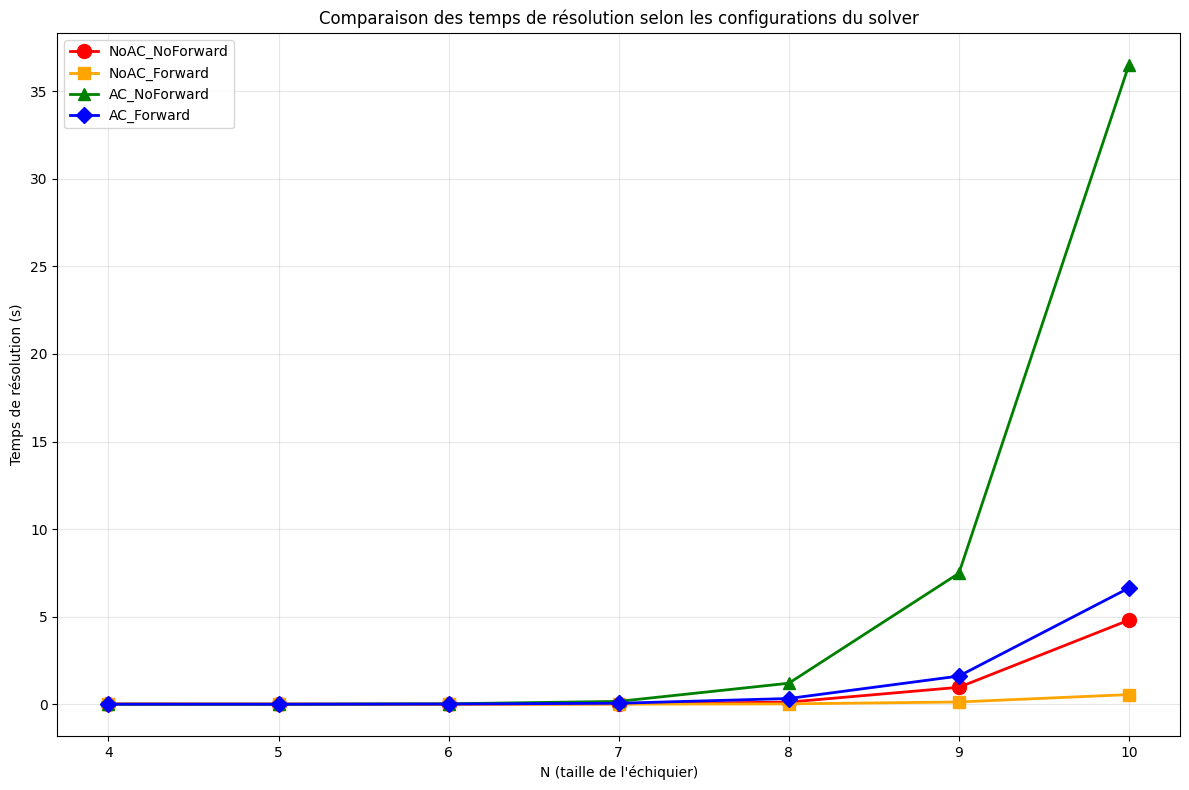

In [7]:
# Configuration des graphiques
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Filtrer les données valides (exclure les erreurs et timeouts)
valid_data = df[df['status'] == 'solved'].copy()

# Couleurs et styles pour chaque configuration (ordre par performance croissante)
colors = ['red', 'orange', 'green', 'blue']  # Rouge pour NoAC_NoForward (le plus lent)
markers = ['o', 's', '^', 'D']
markersizes = [10, 8, 8, 8]  # Marqueur plus gros pour NoAC_NoForward

# Créer les courbes pour chaque configuration
for i, config_name in enumerate(SOLVER_CONFIGS.keys()):
    config_data = valid_data[valid_data['config_name'] == config_name].sort_values('n')
    if len(config_data) > 0:
        ax.plot(config_data['n'], config_data['solving_time'], 
                color=colors[i], marker=markers[i], linewidth=2, markersize=markersizes[i],
                label=config_name)

ax.set_xlabel('N (taille de l\'échiquier)')
ax.set_ylabel('Temps de résolution (s)')
ax.set_title('Comparaison des temps de résolution selon les configurations du solver')
ax.grid(True, alpha=0.3)
# ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

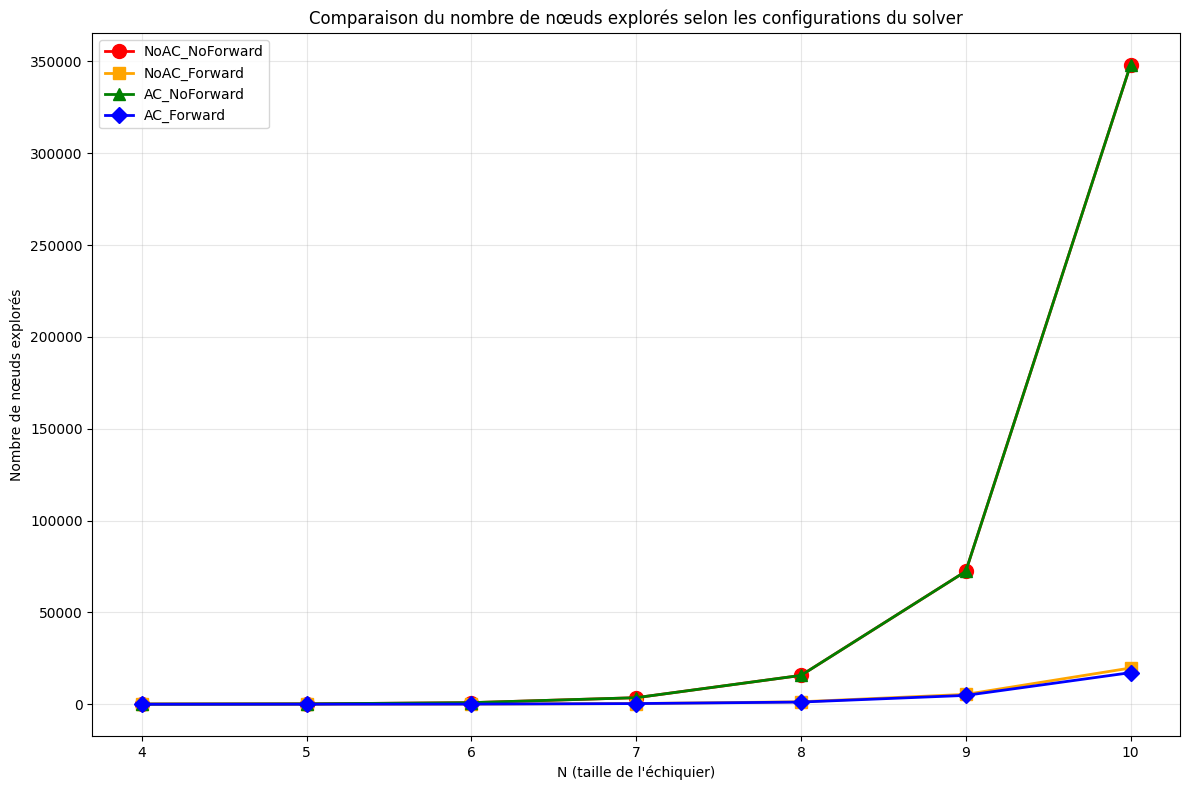

In [8]:
# Configuration des graphiques pour les nœuds explorés
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Filtrer les données valides (exclure les erreurs et timeouts)
valid_data = df[df['status'] == 'solved'].copy()

# Couleurs et styles pour chaque configuration (même ordre que le graphique de performance)
colors = ['red', 'orange', 'green', 'blue']  # Rouge pour NoAC_NoForward (le plus lent)
markers = ['o', 's', '^', 'D']
markersizes = [10, 8, 8, 8]  # Marqueur plus gros pour NoAC_NoForward

# Créer les courbes pour chaque configuration
for i, config_name in enumerate(SOLVER_CONFIGS.keys()):
    config_data = valid_data[valid_data['config_name'] == config_name].sort_values('n')
    if len(config_data) > 0:
        ax.plot(config_data['n'], config_data['nodes_explored'], 
                color=colors[i], marker=markers[i], linewidth=2, markersize=markersizes[i],
                label=config_name)

ax.set_xlabel('N (taille de l\'échiquier)')
ax.set_ylabel('Nombre de nœuds explorés')
ax.set_title('Comparaison du nombre de nœuds explorés selon les configurations du solver')
ax.grid(True, alpha=0.3)
# ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

## Tableau détaillé des résultats


In [9]:
# Afficher le tableau des résultats avec le nombre de nœuds
print("=== RÉSULTATS DU BENCHMARK AVEC NŒUDS EXPLORÉS ===")
print(df[['n', 'config_name', 'solving_time', 'nodes_explored', 'backtracks']].to_string(index=False))

# Statistiques générales pour les nœuds
print("\n=== STATISTIQUES NŒUDS EXPLORÉS ===")
if len(valid_data) > 0:
    print(f"Nombre de nœuds explorés global:")
    print(f"  Minimum: {valid_data['nodes_explored'].min():,}")
    print(f"  Maximum: {valid_data['nodes_explored'].max():,}")
    print(f"  Moyenne: {valid_data['nodes_explored'].mean():,.0f}")
    print(f"  Médiane: {valid_data['nodes_explored'].median():,.0f}")
    
    # Analyse par configuration pour les nœuds
    print(f"\nComparaison par configuration (nœuds explorés):")
    for config_name in SOLVER_CONFIGS.keys():
        config_data = valid_data[valid_data['config_name'] == config_name]
        if len(config_data) > 0:
            print(f"  {config_name}:")
            print(f"    Nœuds moyens: {config_data['nodes_explored'].mean():,.0f}")
            print(f"    Nœuds max: {config_data['nodes_explored'].max():,}")
            print(f"    Temps moyen: {config_data['solving_time'].mean():.3f}s")
            print(f"    Efficacité (nœuds/s): {config_data['nodes_explored'].sum() / config_data['solving_time'].sum():,.0f}")
else:
    print("Aucune donnée valide disponible")

=== RÉSULTATS DU BENCHMARK AVEC NŒUDS EXPLORÉS ===
 n    config_name  solving_time  nodes_explored  backtracks
 4 NoAC_NoForward      0.018206              96          25
 4   NoAC_Forward      0.013133              21          15
 4   AC_NoForward      0.001000              96          25
 4     AC_Forward      0.005977              16          13
 5 NoAC_NoForward      0.007603             220          53
 5   NoAC_Forward      0.008899              53          49
 5   AC_NoForward      0.003000             220          53
 5     AC_Forward      0.003000              49          49
 6 NoAC_NoForward      0.003000             894         152
 6   NoAC_Forward      0.001000             118          82
 6   AC_NoForward      0.027000             894         152
 6     AC_Forward      0.014000             108          78
 7 NoAC_NoForward      0.025000            3584         551
 7   NoAC_Forward      0.006000             393         325
 7   AC_NoForward      0.165000            3584  

In [10]:
# Sauvegarder les résultats en CSV
detailed_df = df[['n', 'config_name', 'solving_time', 'nodes_explored', 'backtracks']].copy()
detailed_df.columns = ['N', 'Configuration', 'Temps_Resolution', 'Noeuds_Explores', 'Backtracks']
detailed_df = detailed_df.round(3)
detailed_df.to_csv('queen_benchmark_results.csv', index=False)
print("\nRésultats sauvegardés dans 'queen_benchmark_results.csv'")


Résultats sauvegardés dans 'queen_benchmark_results.csv'


## Analyse des performances

In [11]:
if len(valid_data) > 0:
    print(f"\nInstances résolues avec succès: {len(valid_data)}/{len(df)}")
    print(f"Taux de succès: {len(valid_data)/len(df)*100:.1f}%")
    
    print(f"\nTemps de résolution global:")
    print(f"  Minimum: {valid_data['solving_time'].min():.3f}s")
    print(f"  Maximum: {valid_data['solving_time'].max():.3f}s")
    print(f"  Moyenne: {valid_data['solving_time'].mean():.3f}s")
    print(f"  Médiane: {valid_data['solving_time'].median():.3f}s")
    
    # Analyse par configuration
    print(f"\nComparaison par configuration:")
    for config_name in SOLVER_CONFIGS.keys():
        config_data = valid_data[valid_data['config_name'] == config_name]
        if len(config_data) > 0:
            print(f"  {config_name}:")
            print(f"    Temps moyen: {config_data['solving_time'].mean():.3f}s")
            print(f"    Temps max: {config_data['solving_time'].max():.3f}s")


Instances résolues avec succès: 28/28
Taux de succès: 100.0%

Temps de résolution global:
  Minimum: 0.001s
  Maximum: 36.506s
  Moyenne: 2.169s
  Médiane: 0.026s

Comparaison par configuration:
  NoAC_NoForward:
    Temps moyen: 0.850s
    Temps max: 4.806s
  NoAC_Forward:
    Temps moyen: 0.105s
    Temps max: 0.553s
  AC_NoForward:
    Temps moyen: 6.483s
    Temps max: 36.506s
  AC_Forward:
    Temps moyen: 1.237s
    Temps max: 6.638s
